In [1]:
import matplotlib.pyplot as plt

In [2]:
from database import Database, LoadDatabase
import numpy as np

In [3]:
db = LoadDatabase()
sortedStandings = [(k,v) for k,v in sorted(db.standings.items(),
                   key=lambda x: db.contests.loc[x[0]].startTime)]

In [32]:
from database import Database, LoadDatabase
import numpy as np
import scipy as sp

# return value: ans, userRatings
#   ans - dict of contestId: average error of expected ranking
#   userRatings: dict of handle: inner rating class with EloRating specific measures
# parameters:
#   - consider: eg. consider=50, will consider only 50 first contests (-1 means consider all)
#   - verbose: print verbosely
#   - basicRating: Ranking with which the user is starting
#   - k: constant scaling how many points will be gained in a duel
#   - eloConst1: constant by which the rating difference is divided in sigmoid function
#   - eloConst2: consant which is raised to the power in sigmoid function

def EloRatingSystem(data, consider=50, verbose=False, basicRating = 1200, k = 1, eloConst1 = 100, eloConst2 = 10, errFunc=None, **kwargs):

    class Rating:
        def __init__(self):
            self.ratings = []
        
        def getRating(self):
            if len(self.ratings) == 0:
                return basicRating
            return self.ratings[len(self.ratings)-1]

        def addRating(self, rating):
            self.ratings.append(rating)

    userRatings = {}

    def addNewUsers(standings):
        for handle in standings.index:
            if not handle in userRatings:
                userRatings[handle] = Rating()

    def getRatings(standings):
        return [(handle, userRatings[handle].getRating()) for handle in standings.index]

    def calcEloDiff(myRating, enemyRating, myRank1, enemyRank):
        exp = (enemyRating - myRating) / eloConst1
        expectedScore = 1/(1 + eloConst2**exp)

        score = 0
        if myRank1 < enemyRank:
            score = 1
        elif myRank1 == enemyRank:
            score = 0.5

        return k * (score - expectedScore)


    def calcNewRating(handle, ranksAndRatings):
        oldRating = userRatings[handle].getRating()
        rank = standings.loc[handle]["rank"]
        diff = 0

        for enemyRank, enemyRating in ranksAndRatings:
            diff += calcEloDiff(oldRating, enemyRating, rank, enemyRank)
        # Removing diff from myself    
        diff -= calcEloDiff(oldRating, oldRating, rank, rank)
        #diff /= (len(standings.index) - 1)
        
        return oldRating + diff

    def calcExpectedRanksFromRatings(ratings):
        sortedRatings = sorted(ratings, key=lambda x: -x[1])
        ranks = np.empty(len(sortedRatings))
        i = 0
        while i < len(ranks):
            j = i
            rating = sortedRatings[i][1]
            while j + 1 < len(ranks) and sortedRatings[j + 1][1] == rating:
                j += 1
            ranks[i:j+1] = (i + 1 + j + 1) / 2
            i = j + 1
        return [(handle, ranks[i]) for i, (handle, _) in enumerate(sortedRatings)]

    def calcErrorRate(expectedRanks, standings):
        res = 0.0
        if(errFunc is None):
            for handle, rank in expectedRanks:
                res += abs(rank - standings.loc[handle]["rank"])
        else:
            for handle, rank in expectedRanks:
                res += errFunc(rank - standings.loc[handle]["rank"])
        return res / len(expectedRanks)

    
    sortedStandings = [(k,v) for k,v in sorted(data.standings.items(),
                        key=lambda x: data.contests.loc[x[0]].startTime)]
    if consider != -1:
        sortedStandings = sortedStandings[:consider]
    standingsLeft = len(sortedStandings)
    ans = {}

    for contestId, standings in sortedStandings:
        standings = standings.copy()
        if verbose:
            print("Standings left:", standingsLeft, "contestId:", contestId)
        standingsLeft -= 1
        addNewUsers(standings)
        ratings = getRatings(standings)
        expectedRanks = calcExpectedRanksFromRatings(ratings)
        ans[contestId] = calcErrorRate(expectedRanks, standings)

        ratingUpdate = {}
        ranksAndRatings = []
        
        for handle in standings.index:
            rating = userRatings[handle].getRating()
            ranks = standings.loc[handle]["rank"]
            ranksAndRatings.append([ranks, rating])
        
        for handle in standings.index:
            newrating = calcNewRating(handle, ranksAndRatings)
            ratingUpdate[handle] = newrating

        for handle in standings.index:
            userRatings[handle].addRating(ratingUpdate[handle])

    return ans, userRatings


In [33]:
from datetime import datetime

now = datetime.now()
 
print("now =", now)

now = 2021-01-28 13:36:30.265559


In [34]:
consider = 200

In [35]:
ans, userRatings = EloRatingSystem(db, consider=consider, verbose=True)

Standings left: 200 contestId: 26
Standings left: 199 contestId: 27
Standings left: 198 contestId: 28
Standings left: 197 contestId: 29
Standings left: 196 contestId: 30
Standings left: 195 contestId: 31
Standings left: 194 contestId: 32
Standings left: 193 contestId: 33
Standings left: 192 contestId: 34
Standings left: 191 contestId: 35
Standings left: 190 contestId: 36
Standings left: 189 contestId: 37
Standings left: 188 contestId: 40
Standings left: 187 contestId: 41
Standings left: 186 contestId: 42
Standings left: 185 contestId: 43
Standings left: 184 contestId: 47
Standings left: 183 contestId: 49
Standings left: 182 contestId: 51
Standings left: 181 contestId: 53
Standings left: 180 contestId: 54
Standings left: 179 contestId: 55
Standings left: 178 contestId: 56
Standings left: 177 contestId: 57
Standings left: 176 contestId: 58
Standings left: 175 contestId: 59
Standings left: 174 contestId: 60
Standings left: 173 contestId: 61
Standings left: 172 contestId: 62
Standings left

In [36]:
now = datetime.now()
 
print("now =", now)
ans

now = 2021-01-28 13:38:29.221383


{26: 126.83889980353635,
 27: 117.91773778920309,
 28: 89.14248021108179,
 29: 110.0,
 30: 117.04561403508772,
 31: 114.643391521197,
 32: 71.05416666666666,
 33: 123.75244299674267,
 34: 119.09024390243903,
 35: 75.30923694779116,
 36: 79.95949367088608,
 37: 143.4913043478261,
 40: 140.4569536423841,
 41: 118.37566137566138,
 42: 121.19814814814815,
 43: 111.99738219895288,
 47: 105.11051212938006,
 49: 106.725,
 51: 122.43607705779334,
 53: 79.88846153846154,
 54: 82.82275711159737,
 55: 87.10752688172043,
 56: 117.18829516539441,
 57: 120.14871016691957,
 58: 129.45558086560365,
 59: 109.18604651162791,
 60: 148.73469387755102,
 61: 121.84018264840182,
 62: 43.78,
 63: 108.11940298507463,
 65: 178.75120192307693,
 66: 163.49136577708006,
 67: 158.64429530201343,
 68: 177.29942196531792,
 69: 179.14792899408283,
 70: 175.5819397993311,
 71: 186.8012048192771,
 73: 125.5015923566879,
 75: 145.03861003861005,
 74: 166.94390243902438,
 77: 93.38055555555556,
 80: 185.62310866574967,
 7

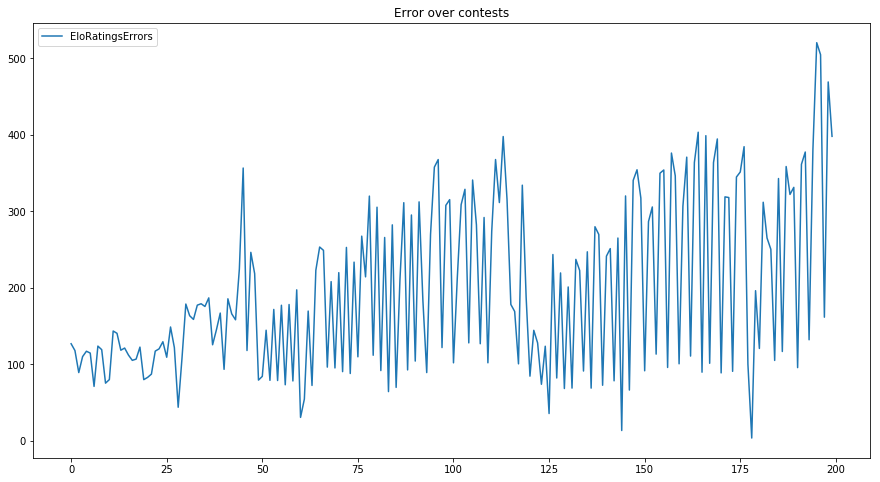

In [38]:
arr = np.array(list(ans.values()))
xs = np.arange(len(arr))
plt.figure(figsize=(15, 8))
plt.plot(xs, arr, label="EloRatingsErrors")
plt.title("Error over contests")
plt.legend()
plt.show()

In [39]:
arr = np.array(list(ans.values()))
print(np.mean(arr))
print(np.std(arr))
arr = np.sort(arr)
print(arr.sum())

196.62459541157486
111.11074142775847
39324.91908231497


In [40]:
def getPlaces(handle):
    ans = []
    for contestId, standings in sortedStandings[:consider]:
        if handle in standings.index:
            ans.append(standings.loc[handle]["rank"])
    return ans

def getRatings(handle):
    ans = []
    for contestId, standings in sortedStandings[:consider]:
        if handle in standings.index:
            ans.append(standings.loc[handle]["newRating"])
    return ans

def getRandomUser(threshold=20):
    x = np.random.choice([handle for handle, r in userRatings.items()])
    while len(userRatings[x].ratings) < threshold:
        x = np.random.choice([handle for handle, r in userRatings.items()])
    return x

def compareSystems(handle):
    eloRatings = userRatings[handle].ratings
    cfRatings = getRatings(handle)
    print("number of contests", len(cfRatings))
    assert len(eloRatings) == len(cfRatings)
    xs = np.arange(len(eloRatings))

    plt.figure(figsize=(15, 8))
    plt.plot(xs, eloRatings, label="EloRatings")
    plt.plot(xs, cfRatings, label="CodeForces")
    plt.title(handle)
    plt.legend()
    plt.show()

[415, 113, 322, 426, 56, 15, 374, 711, 97, 538, 534, 733]
[1263, 1406, 1517, 1447, 1571, 1648, 1574, 1502, 1637, 1568, 1523, 1445]
[1038.5, 1265.0450565110402, 1187.7703502270556, 1127.2721820274062, 1291.591304160274, 1371.9705594536804, 1076.9853583485396, 931.5880333828641, 1821.684887969682, 1278.6031531824428, 1289.2576542916354, 1115.0890530361562]
number of contests 12


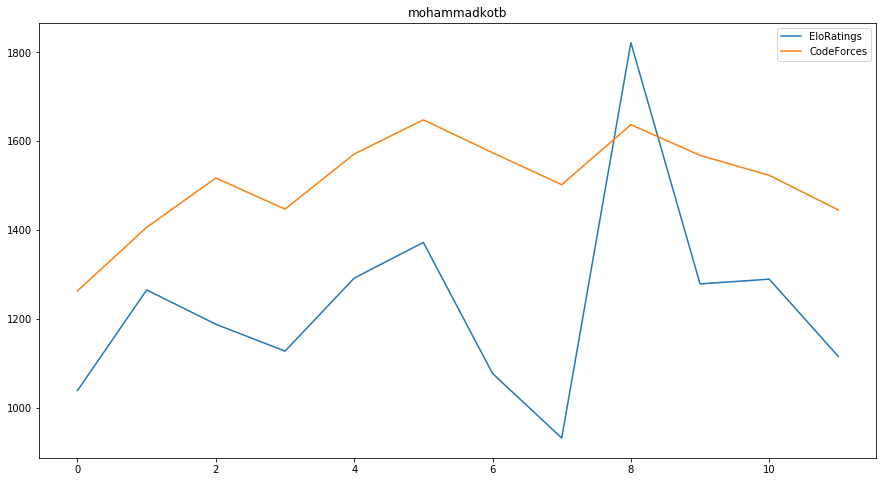

In [41]:
handle = 'mohammadkotb'
print(getPlaces(handle))
print(getRatings(handle))
print(userRatings[handle].ratings)
compareSystems(handle)

number of contests 25


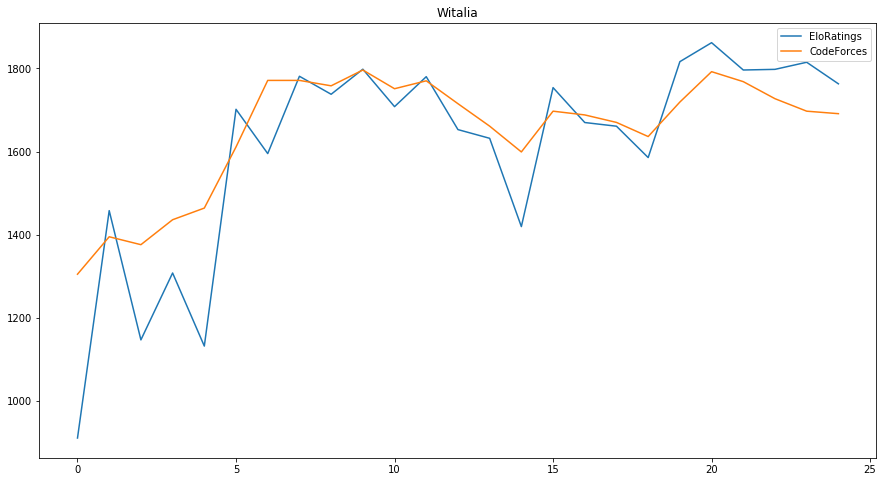

In [42]:
handle = getRandomUser()
compareSystems(handle)

[11, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 11, 1, 1, 1, 2, 4, 2, 7, 4, 5, 2, 7, 22, 4, 1, 3, 1, 1, 2, 5, 3, 1, 1, 10, 1, 1, 3, 1, 2, 1, 8, 1, 2, 1, 2, 1, 3, 3, 4, 2, 1, 6, 1, 11, 2, 3]
[2128, 2203, 2256, 2311, 2341, 2388, 2419, 2438, 2455, 2491, 2494, 2517, 2501, 2514, 2547, 2586, 2624, 2632, 2646, 2610, 2609, 2604, 2613, 2601, 2549, 2560, 2595, 2612, 2661, 2683, 2693, 2670, 2704, 2762, 2809, 2783, 2831, 2877, 2883, 2907, 2906, 2919, 2877, 2887, 2902, 2938, 2964, 3022, 3010, 2998, 2973, 2991, 3042, 2977, 3082, 3016, 3030, 3026]
[1420.619304343103, 1472.214260613228, 1503.8954543373895, 1528.4059114872805, 1546.2040541154772, 1562.602745378226, 1574.7591610732406, 1588.1416224923569, 1596.1573473317092, 1624.2681734587889, 1659.4274976136937, 1684.0890843680584, 1696.223400764161, 1742.1360219040446, 1823.264438502803, 1912.1420947684546, 1952.1007147963694, 1963.6980730347348, 1971.2210549185884, 1970.28053712353, 1969.5742357406837, 1967.7063743247413, 1969.0177899931728, 1966.660512736580

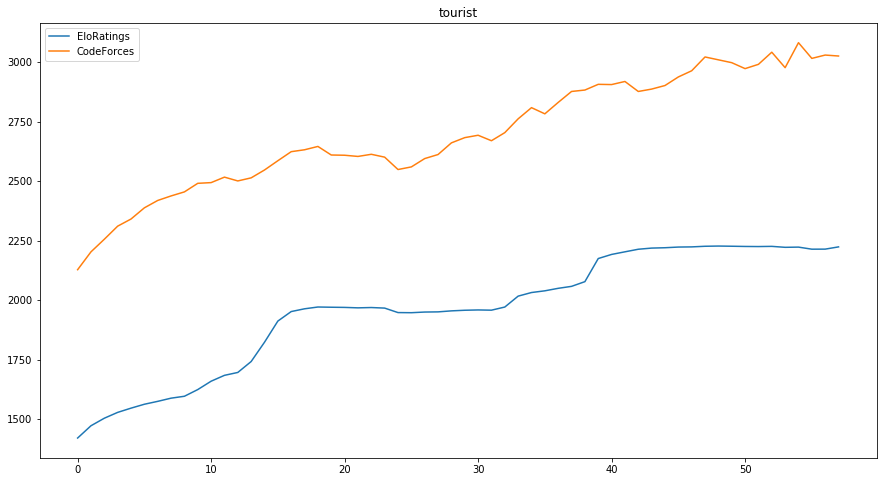

In [43]:
handle = 'tourist'
print(getPlaces(handle))
print(getRatings(handle))
print(userRatings[handle].ratings)
compareSystems(handle)

[621, 1075, 325, 662, 827, 1276, 940, 795, 331, 989, 631, 1193, 419, 399, 744, 618, 702, 433, 1024, 624]
[1455, 1374, 1512, 1467, 1412, 1333, 1290, 1314, 1502, 1422, 1396, 1316, 1403, 1460, 1405, 1406, 1382, 1476, 1409, 1471]
[1215.8745948301514, 808.9613116937919, 1764.9240650816782, 1181.8163404103962, 1184.748113777621, 747.5048332508005, 1092.8515795959213, 1212.7333047030222, 1730.8098114117204, 846.7460193374935, 1343.210690686497, 628.3591361313418, 1319.658796303223, 1389.6053822442775, 1042.518219139812, 1349.762567779687, 1131.7515477081733, 1586.5030633861404, 888.1782287222213, 1628.5225440049833]
number of contests 20


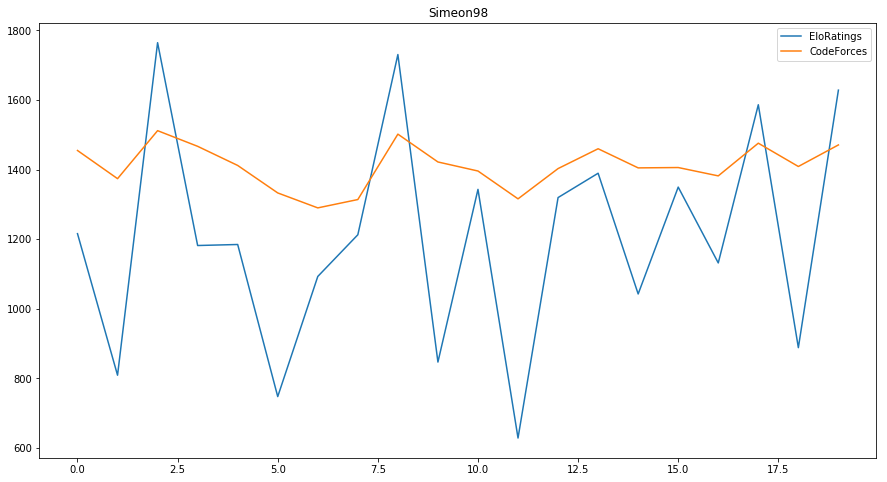

In [44]:
handle = 'Simeon98'
print(getPlaces(handle))
print(getRatings(handle))
print(userRatings[handle].ratings)
compareSystems(handle)


number of contests 12


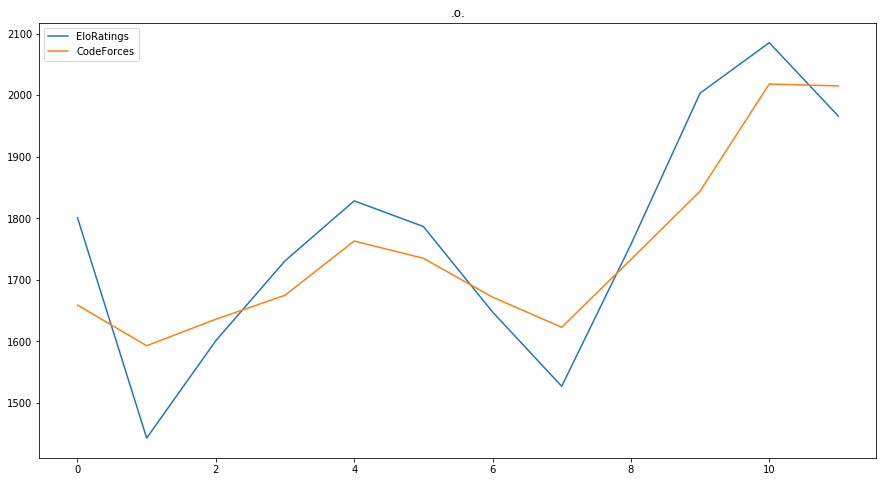

In [45]:
handle = '.o.'
compareSystems(handle)

number of contests 78


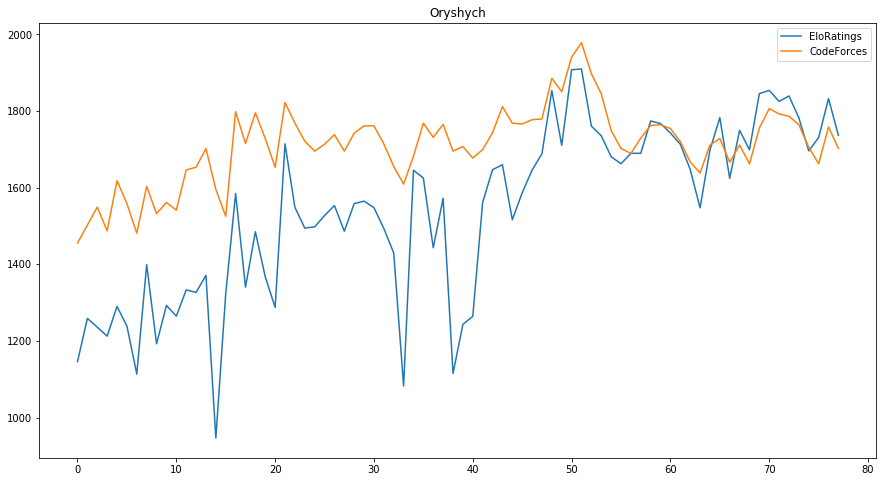

In [46]:
handle = getRandomUser(threshold=60)
compareSystems(handle)

number of contests 62


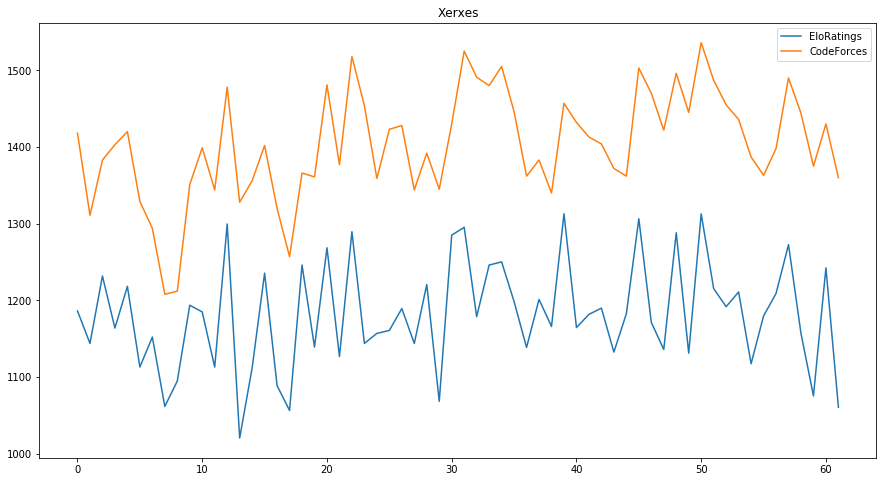

In [85]:
handle = getRandomUser(threshold=60)
compareSystems(handle)

[357, 122, 300, 284, 407, 164, 63, 538, 307, 141, 335, 498, 25, 287, 91, 82, 433, 5, 273, 417, 318, 448, 56, 599, 220, 319, 475, 98, 400, 788, 470, 583, 316, 413, 318, 618, 382, 166, 741, 1509, 263, 794, 265, 361, 372, 637, 371, 744, 423, 281, 408, 599, 480, 788, 577, 796, 205, 670, 820, 945, 1134, 832, 198, 907, 814, 818, 627]
[1119.6850393700788, 1298.0070096186607, 1047.3184440254881, 1073.6914312864826, 1086.5095081824738, 1220.8380025503793, 1223.0483195245877, 1055.1466885684695, 1082.6516168720307, 1161.8420249483038, 1115.7378969124793, 1077.850073520745, 1355.517468885611, 1215.990709370475, 1240.6610411331721, 1235.4458058474518, 1153.55275291207, 1345.362851883595, 1203.2259874416432, 1074.206218716999, 1019.7869347837445, 1123.0101787734866, 1309.1574959829752, 1136.227428295386, 1150.9105513237118, 1026.6079413893592, 1093.2043647056075, 1345.7494702288013, 1152.9961017441524, 1089.0209604904583, 1122.6972015418817, 1189.1691256074134, 1169.6774492396034, 1139.440600791384

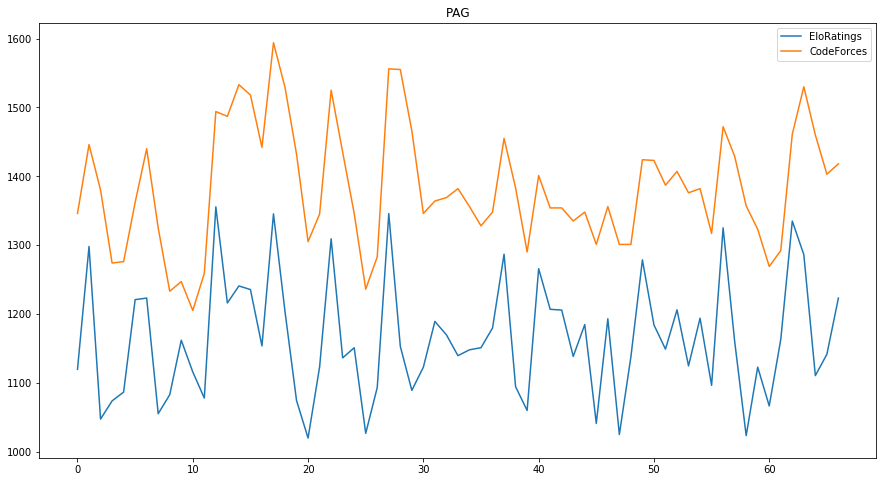

In [86]:
handle = getRandomUser(threshold=60)
print(getPlaces(handle))
print(userRatings[handle].ratings)
compareSystems(handle)

number of contests 65


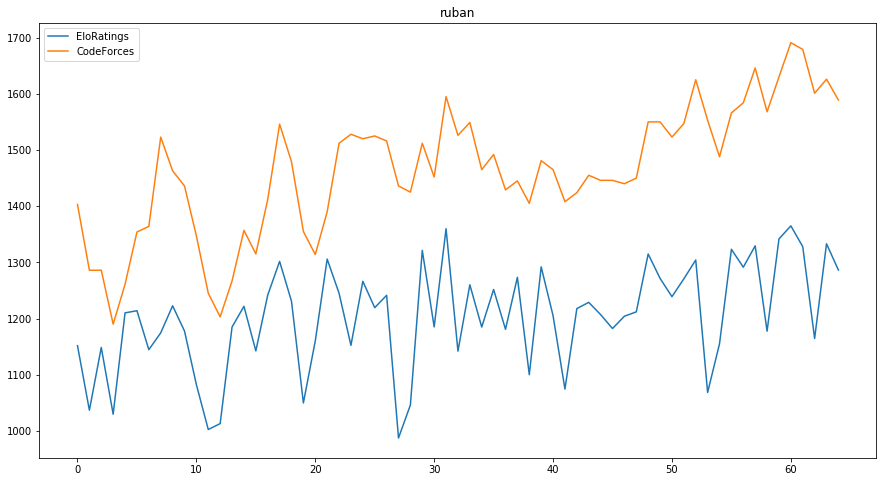

In [87]:
handle = getRandomUser(threshold=60)
compareSystems(handle)

number of contests 65


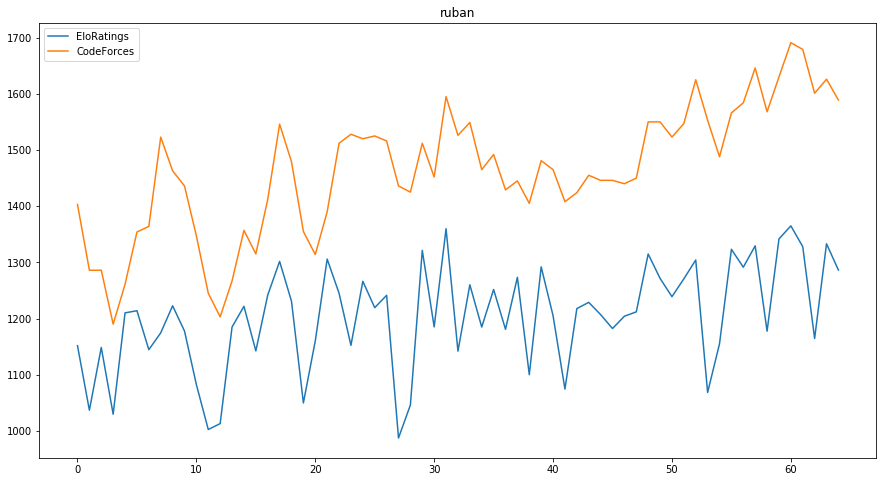

In [88]:
handle = getRandomUser(threshold=60)
compareSystems(handle)

In [89]:
handle = getRandomUser(threshold=70)
compareSystems(handle)

KeyboardInterrupt: 

number of contests 49


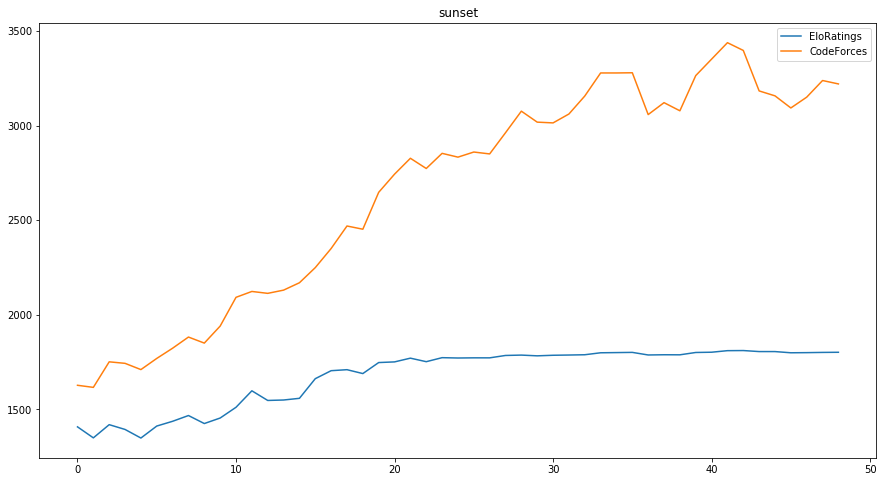

In [69]:
handle = 'sunset'
compareSystems(handle)

number of contests 96


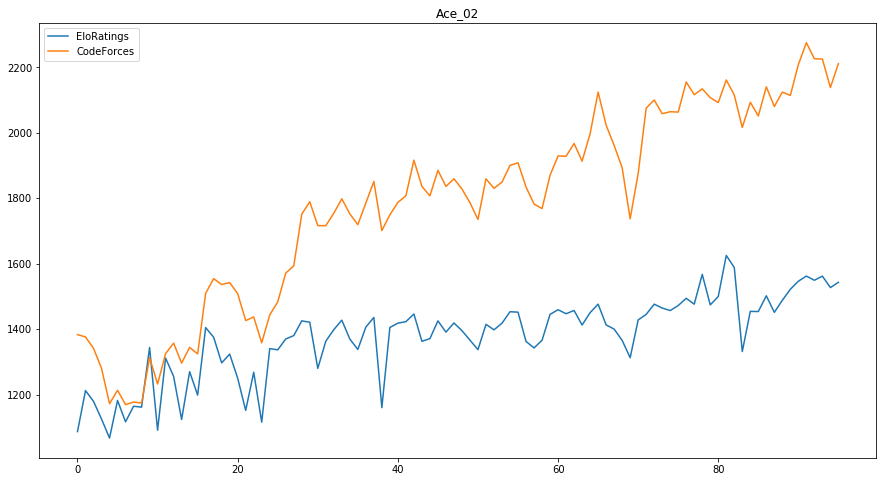

In [56]:
handle = getRandomUser(threshold=90)
compareSystems(handle)

number of contests 140


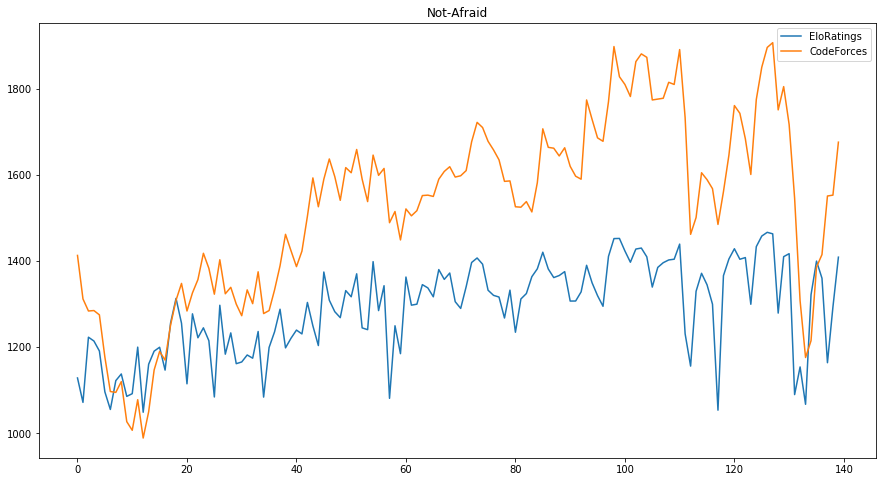

In [57]:
handle = getRandomUser(threshold=90)
compareSystems(handle)

number of contests 166


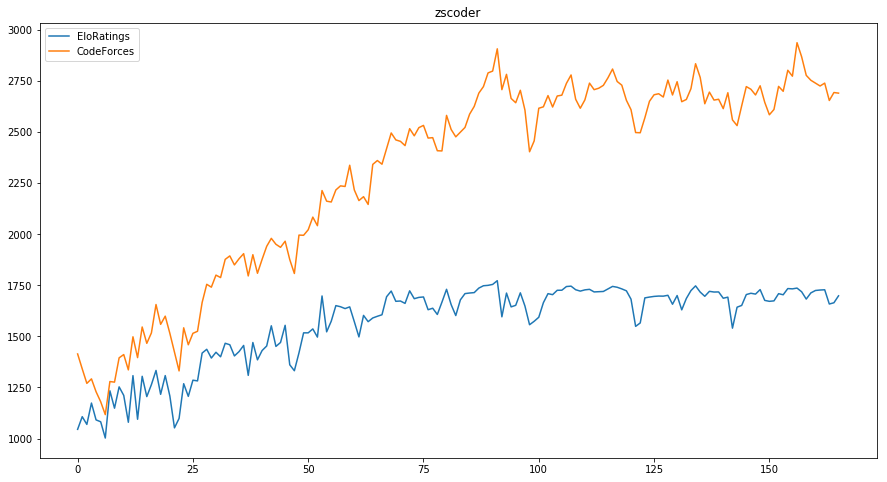

In [58]:
handle = getRandomUser(threshold=100)
compareSystems(handle)

number of contests 121


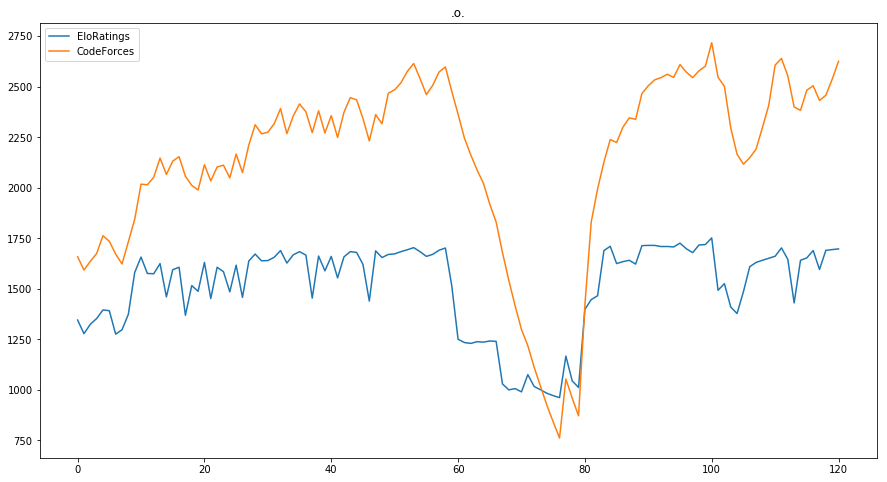

In [59]:
handle = getRandomUser(threshold=120)
compareSystems(handle)

In [48]:
class CFRatingPredictor:
    def __init__(self, db):
        self.standings = db.standings
        self.contests = list(db.contests.index)
        self.contests.reverse()

    def intDiv(self, x,y):
        return - ((-x) // y) if x < 0 else x // y

    def Pij(self, ri, rj):
        return 1.0 / (1.0 + np.power(10.0, (rj-ri)/400.0))

    def getSeed(self, rating, contestant, contestStandings):
        prob = lambda r : self.Pij(r, rating)
        vecProb = np.vectorize(prob)
        oldRatings = contestStandings['oldRating'].to_numpy()
        seed = np.sum(vecProb(oldRatings)) - self.Pij(contestant['oldRating'],rating) + 1
        return seed

    def getSeedCached(self, npCS):
        cache = {}
        def seedCacher(rating):
            if rating not in cache:
                prob = lambda r: self.Pij(r, rating)
                vecProb = np.vectorize(prob)
                cache[rating] = np.sum(vecProb(npCS)) + 0.5
            return cache[rating]

        return seedCacher

    def getInitialRatingChange(self, contestant, contestStandings):
        rank = contestant['rank']
        oldRating = contestant['oldRating']
        seed = self.getSeed(oldRating, contestant, contestStandings)
        midRank = np.sqrt(rank*seed)
        R = self.binarySearch(midRank, lambda r: self.getSeed(r, contestant, contestStandings))
        delta = self.intDiv(R-oldRating,2)
        return delta

    def binarySearch(self, value, f, left=1, right=8000):
        while right - left > 1:
            mid = self.intDiv(left+right,2)
            print(left, right)
            print(mid, f(mid), value)
            if f(mid) < value:
                right = mid
            else:
                left = mid
        return left

    def fightAgainstInflation(self, contestStandings, deltas):
        contestantsSorted = contestStandings.sort_values(by=['oldRating'], ascending=False)
        pplCount = len(contestStandings)
        topPplCount = (min(pplCount, 4*(np.rint(np.sqrt(pplCount))))).astype(int)
        topContestans = contestantsSorted.head(topPplCount)
        sum = np.sum([deltas[i] for i in topContestans.index])
        inc = min(0, max(-10, -(self.intDiv(sum, topPplCount))))
        print(inc)
        return deltas + inc

    def fixToSumZero(self, contestStandings, deltas):
        sum = np.sum(deltas)
        inc = -self.intDiv(sum, len(contestStandings)) - 1
        return deltas + inc

    def processContest(self, contestStandings):
        deltas = contestStandings.apply(lambda c: self.getInitialRatingChange(c, contestStandings), axis=1)   
        deltas = self.fixToSumZero(contestStandings, deltas)
        deltas = self.fightAgainstInflation(contestStandings, deltas)
        return deltas

    def calcErrorContest(self, contestStandings, errCalc):
        npCS = contestStandings['oldRating'].to_numpy()
        seedCalculator = self.getSeedCached(npCS)
        expectedRanks = contestStandings.apply(lambda c: seedCalculator(c['oldRating']), axis=1).to_numpy()
        actualRanks = contestStandings['oldRating'].to_numpy()
        vecErrCalc = np.vectorize(errCalc)
        return np.sum(vecErrCalc(expectedRanks, actualRanks)) / len(contestStandings)

    def genErrRateDic(self, errCalc):
        errRateDic = {}
        for key in self.contests:
            contestStandings = self.standings[key]
            print("Contest ", key, " started")
            print("There are ", len(contestStandings), " participants in this contest")
            errRateDic[key] = self.calcErrorContest(contestStandings, errCalc)
            print("Contest ", key, " is done!")
        return errRateDic

def GenCFRatingErrors(DB, errCalc):
    rp = CFRatingPredictor(DB)
    return rp.genErrRateDic(errCalc)

def AnadiErrorRate(a, b):
    return abs(a-b)

In [49]:
cferr = GenCFRatingErrors(db, AnadiErrorRate)

Contest  26  started
There are  509  participants in this contest
Contest  26  is done!
Contest  27  started
There are  389  participants in this contest
Contest  27  is done!
Contest  28  started
There are  379  participants in this contest
Contest  28  is done!
Contest  29  started
There are  355  participants in this contest
Contest  29  is done!
Contest  30  started
There are  570  participants in this contest
Contest  30  is done!
Contest  31  started
There are  401  participants in this contest
Contest  31  is done!
Contest  32  started
There are  240  participants in this contest
Contest  32  is done!
Contest  33  started
There are  614  participants in this contest
Contest  33  is done!
Contest  34  started
There are  410  participants in this contest
Contest  34  is done!
Contest  35  started
There are  249  participants in this contest
Contest  35  is done!
Contest  36  started
There are  395  participants in this contest
Contest  36  is done!
Contest  37  started
There are  

Contest  137  is done!
Contest  138  started
There are  345  participants in this contest
Contest  138  is done!
Contest  139  started
There are  1123  participants in this contest
Contest  139  is done!
Contest  140  started
There are  1896  participants in this contest
Contest  140  is done!
Contest  141  started
There are  1262  participants in this contest
Contest  141  is done!
Contest  142  started
There are  422  participants in this contest
Contest  142  is done!
Contest  143  started
There are  1254  participants in this contest
Contest  143  is done!
Contest  144  started
There are  1357  participants in this contest
Contest  144  is done!
Contest  145  started
There are  341  participants in this contest
Contest  145  is done!
Contest  146  started
There are  938  participants in this contest
Contest  146  is done!
Contest  148  started
There are  1319  participants in this contest
Contest  148  is done!
Contest  149  started
There are  1347  participants in this contest
Con

Contest  254  is done!
Contest  255  started
There are  1446  participants in this contest
Contest  255  is done!
Contest  256  started
There are  460  participants in this contest
Contest  256  is done!
Contest  257  started
There are  1354  participants in this contest
Contest  257  is done!
Contest  258  started
There are  493  participants in this contest
Contest  258  is done!
Contest  259  started
There are  1446  participants in this contest
Contest  259  is done!
Contest  260  started
There are  1353  participants in this contest
Contest  260  is done!
Contest  261  started
There are  435  participants in this contest
Contest  261  is done!
Contest  262  started
There are  1466  participants in this contest
Contest  262  is done!
Contest  263  started
There are  1591  participants in this contest
Contest  263  is done!
Contest  264  started
There are  566  participants in this contest
Contest  264  is done!
Contest  265  started
There are  1525  participants in this contest
Con

Contest  362  is done!
Contest  363  started
There are  1129  participants in this contest
Contest  363  is done!
Contest  364  started
There are  613  participants in this contest
Contest  364  is done!
Contest  365  started
There are  1861  participants in this contest
Contest  365  is done!
Contest  366  started
There are  1609  participants in this contest
Contest  366  is done!
Contest  367  started
There are  659  participants in this contest
Contest  367  is done!
Contest  368  started
There are  1888  participants in this contest
Contest  368  is done!
Contest  369  started
There are  2021  participants in this contest
Contest  369  is done!
Contest  370  started
There are  1144  participants in this contest
Contest  370  is done!
Contest  371  started
There are  1342  participants in this contest
Contest  371  is done!
Contest  372  started
There are  675  participants in this contest
Contest  372  is done!
Contest  373  started
There are  1657  participants in this contest
Co

KeyboardInterrupt: 